In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams['text.usetex'] = True

# Set fonts for Matplotlib
plt.rcParams['font.serif'] = 'Palatino'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.monospace'] = 'Courier'
plt.rcParams['font.size'] = 11

width_cm = 15
height_cm = 8
# Convert centimeters to inches
width_in = width_cm / 2.54
height_in = height_cm / 2.54

import seaborn as sns
sns.set_theme()
figsize= (width_in, height_in)
halffigsize = (width_in/2, height_in)


import os
from metrics.plotting_utils import save_plot, get_history_from_project, save_csv, get_dataset_name_mapping
import numpy as np
import pandas as pd 
import wandb
api = wandb.Api()
from ood_detection.config import Config
from datasets.config import DATASETS_DICT


frame_name = "thesis-zsoodd_10_runs-std"
name_mapping = get_dataset_name_mapping()
aucs = ['auc-mean', 'auc-sum', 'auc-max']

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ZOC

In [2]:
full_zoc = get_history_from_project(frame_name)
working_zoc = full_zoc.copy()
working_zoc.drop([col for col in working_zoc.columns if col not in aucs], axis=1, inplace = True)

In [3]:
working_zoc.mean()

auc-mean    0.689494
auc-max     0.628729
auc-sum     0.727194
dtype: float64

## Finetuned Baseline

In [4]:
full_fine = get_history_from_project('thesis-ood_baseline-all-full_classes-test_sets')

In [5]:
working_fine = full_fine.copy()

In [6]:
working_fine.drop(['log_std', 'lin_std'], axis=1, inplace=True)

In [7]:
working_fine.mean()

lin_AUC    0.706488
log_AUC    0.817914
dtype: float64

## MCM

In [8]:
def get_all_finished_runs(methods, runs):
    dfs = {}
    for method in methods:
        for run in runs:
            if method == 'mls' and run != '1.0':
                continue
            name = method +'-'+ run
            print(f"Loading {name}")
            try:
                df = prep_far_ood(name)
                assert len(df) == 132
                dfs[name] = df
            except:
                print(f"{name} not finished yet")
                continue
    return dfs
def plot_errorbar(df, value_column):
    error_corr = .5 * df[value_column + '-std']
    lower = df[value_column] - error_corr
    upper = df[value_column] + error_corr
    if value_column=='LOGISTIC':
        name= 'Fine-tuning + MSP'
    else:
        name=value_column
    #mean = df[value_column].mean().round(3)
    #std = u"\u00B1{})".format(df[value_column+'-std'].mean().round(2))
    #label = name + f' (\u03bc= {mean}' + std
    
    ax.plot(df[value_column], label = name)
    ax.plot(lower, color='tab:blue', alpha=.1)
    ax.plot(upper, color='tab:blue', alpha=.1)
    ax.fill_between(range(len(df)), lower, upper, alpha=.3)

In [9]:
def prep_mcm(name):
    full_name = f'thesis-near-mcm-{name}'
    to_keep = ['auc-max', 'auc-max-std']
    working_df = get_history_from_project(full_name)
    working_df.drop([col for col in working_df.columns if col not in to_keep], axis=1,inplace = True)
    working_df.rename(columns = {'auc-max': name.upper(), 'auc-max-std':name.upper()+'-std'}, inplace=True)
    return working_df

In [10]:
methods = ['mls-1.0', 'msp-0.01', 'msp-1.0','msp-100.0']
full_mcm_df = pd.concat([prep_mcm(m) for m in methods], axis=1)


In [11]:
full_mcm_df = full_mcm_df.sort_index()

### Some Correlation & std metrics

In [12]:
full_mcm_df[['MLS-1.0-std', 'MSP-0.01-std', 'MSP-1.0-std', 'MSP-100.0-std']].mean().mean().round(3)

0.037

In [13]:
full_mcm_df[['MLS-1.0', 'MSP-0.01', 'MSP-1.0', 'MSP-100.0']].corr()

,MLS-1.0,MSP-0.01,MSP-1.0,MSP-100.0
MLS-1.0,1.000000,0.951164,0.971408,0.978608
MSP-0.01,0.951164,1.000000,0.974710,0.976032
MSP-1.0,0.971408,0.974710,1.000000,0.980340
MSP-100.0,0.978608,0.976032,0.980340,1.000000


/tmp/ipykernel_852/1607339380.py:8: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.vlines([range(len(full_mcm_df))], ymin=0, ymax=full_mcm_df.max(axis=1),color='darkgrey', alpha=0.6)
/tmp/ipykernel_852/1607339380.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name_mapping[ind] for ind in full_mcm_df.index], rotation=45, ha='right')


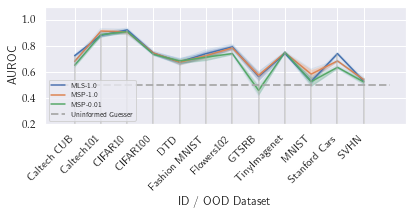

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_2


True

<Figure size 432x288 with 0 Axes>

In [14]:
fig, ax = plt.subplots(figsize=figsize)
plot_errorbar(full_mcm_df, 'MLS-1.0')
plot_errorbar(full_mcm_df, 'MSP-1.0')
plot_errorbar(full_mcm_df, 'MSP-0.01')


ax.hlines(0.5, xmin=-.5, xmax=[len(full_mcm_df)], colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
ax.vlines([range(len(full_mcm_df))], ymin=0, ymax=full_mcm_df.max(axis=1),color='darkgrey', alpha=0.6)

ax.set_ylim(0.2,1.1)
ax.set_xticklabels([name_mapping[ind] for ind in full_mcm_df.index], rotation=45, ha='right')
ax.legend(loc = 'lower left', fontsize=7)
ax.set_xlabel('ID / OOD Dataset')
ax.set_ylabel('AUROC')
# ax.set_title('Near-OOD Detection with Zero-Shot Methods')
plt.tight_layout()
plt.show()
save_plot(fig, 'NearcomparisonMcmLines', '5_2', False)

## Now compare to ZOC and linear Baseline

In [15]:
full_mcm_1 = get_history_from_project('thesis-near-mcm-mls-1.0')
working_mcm_1 = full_mcm_1.copy()
metric_of_interest = ['auc-max', 'auc-max-std']
working_mcm_1.drop([col for col in working_mcm_1.columns if col not in metric_of_interest], axis=1,inplace = True)
working_mcm_1.rename(columns={'auc-max': 'MCM', 'auc-max-std':'MCM-std'}, inplace=True)

In [16]:
# get zoc
full_zoc_1 = get_history_from_project('thesis-zsoodd_10_runs-std')
working = full_zoc_1.copy()
metric_of_interest = ['auc-sum', 'auc-sum-std']
working_zoc = working[metric_of_interest].rename(columns={'auc-sum': 'ZOC', 'auc-sum-std':'ZOC-std'})

In [17]:
# get logistic
full_log = get_history_from_project('thesis-ood_baseline-all-full_classes-test_sets')
logistic = full_log.copy()
logistic = logistic[['log_AUC', 'log_std']]
logistic.rename(columns={'log_AUC': 'LOGISTIC', 'log_std': 'LOGISTIC-std'},inplace=True)

In [18]:
full_near = pd.concat([working_mcm_1,working_zoc, logistic ], axis=1)
full_near = full_near.sort_index()

## Some Corr and STD statistics

### stds...

In [19]:
print("MAX STD")
full_near[[col for col in full_near.columns if "-std" in col]].max().round(3)

MAX STD


MCM-std         0.065
ZOC-std         0.133
LOGISTIC-std    0.111
dtype: float64

In [20]:
print("MEAN STD")
full_near[[col for col in full_near.columns if "-std" in col]].mean().round(3)

MEAN STD


MCM-std         0.032
ZOC-std         0.048
LOGISTIC-std    0.033
dtype: float64

In [21]:
full_near.sort_values('ZOC-std', ascending=False)

,MCM,MCM-std,ZOC,ZOC-std,LOGISTIC,LOGISTIC-std
name,,,,,,
mnist,0.529103,0.037412,0.536436,0.132665,0.938369,0.026611
gtsrb,0.566542,0.065261,0.541935,0.109549,0.791403,0.049798
fashion mnist,0.741620,0.054405,0.800603,0.084744,0.725776,0.111009
caltech101,0.882819,0.030806,0.866118,0.059928,0.920760,0.030890
dtd,0.678434,0.037523,0.674364,0.044412,0.806957,0.026203
svhn,0.530232,0.029659,0.554077,0.035012,0.677759,0.035719
flowers102,0.793749,0.038186,0.829306,0.032651,0.924690,0.021186
cifar100,0.744651,0.026052,0.772430,0.020373,0.787528,0.017793
stanford cars,0.742091,0.015073,0.734188,0.016646,0.778580,0.016526


In [22]:
full_near[['MCM', 'ZOC', 'LOGISTIC']].corr().round(3)

,MCM,ZOC,LOGISTIC
MCM,1.000,0.981,0.401
ZOC,0.981,1.000,0.368
LOGISTIC,0.401,0.368,1.000


In [23]:
full_near[['MCM', 'ZOC', 'LOGISTIC', 'MCM-std', 'ZOC-std', 'LOGISTIC-std']].mean().round(3)

MCM             0.717
ZOC             0.727
LOGISTIC        0.818
MCM-std         0.032
ZOC-std         0.048
LOGISTIC-std    0.033
dtype: float64

#### Without the shitty ones, not that bad

In [24]:
full_near.drop(['mnist', 'svhn', 'gtsrb'])[['MCM', 'ZOC', 'LOGISTIC']].mean().round(3)

MCM         0.775
ZOC         0.788
LOGISTIC    0.823
dtype: float64

In [25]:
def f(x,y):
    return x-y
differences = full_near.copy()
differences['ZOC-MCM'] = differences.apply(lambda x: f(x.ZOC,x.MCM), axis=1)
differences['LOGISTIC-ZOC'] = differences.apply(lambda x: f(x.LOGISTIC,x.ZOC), axis=1)


In [26]:
differences.loc[differences['ZOC-MCM'].idxmax()]

MCM             0.741620
MCM-std         0.054405
ZOC             0.800603
ZOC-std         0.084744
LOGISTIC        0.725776
LOGISTIC-std    0.111009
ZOC-MCM         0.058983
LOGISTIC-ZOC   -0.074828
Name: fashion mnist, dtype: float64

In [27]:
differences.loc[differences['LOGISTIC-ZOC'].idxmax()]

MCM             0.529103
MCM-std         0.037412
ZOC             0.536436
ZOC-std         0.132665
LOGISTIC        0.938369
LOGISTIC-std    0.026611
ZOC-MCM         0.007333
LOGISTIC-ZOC    0.401933
Name: mnist, dtype: float64

In [28]:
full_near.loc[['cifar10', 'cifar100', 'imagenet']]['ZOC']

name
cifar10     0.957453
cifar100    0.772430
imagenet    0.758792
Name: ZOC, dtype: float64

/tmp/ipykernel_852/1003074664.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.vlines([range(len(full_near))], ymin=0, ymax=full_near.max(axis=1),color='darkgrey', alpha=0.6)
/tmp/ipykernel_852/1003074664.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name_mapping[ind] for ind in full_near.index], rotation=45, ha='right')


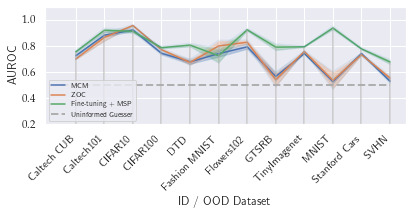

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_2


True

<Figure size 432x288 with 0 Axes>

In [29]:
fig, ax = plt.subplots(figsize=figsize)
plot_errorbar(full_near, 'MCM')
plot_errorbar(full_near, 'ZOC')
plot_errorbar(full_near, 'LOGISTIC')

ax.hlines(0.5, xmin=-.5, xmax=[len(full_near)-1], colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
ax.vlines([range(len(full_near))], ymin=0, ymax=full_near.max(axis=1),color='darkgrey', alpha=0.6)

ax.set_ylim(0.2,1.1)
ax.set_xticklabels([name_mapping[ind] for ind in full_near.index], rotation=45, ha='right')
ax.legend(loc='lower left', fontsize=7)
ax.set_xlabel('ID / OOD Dataset')
ax.set_ylabel('AUROC')
#ax.set_title('Zero-shot and fine-tuned OOD Detection')
plt.tight_layout()
plt.show()
save_plot(fig, 'nearComparisonMZL', '5_2', False)

# Get correletions

In [30]:
from scipy import stats
def line(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return x * slope + intercept 
def plot_line(x,y):
    new_y = line(x,y)
    ax.plot(x,new_y)

In [31]:
log_class = get_history_from_project('thesis-classification-logistic')
log_class.rename(columns={'Acc': 'Logistic Accuracy'})
zsa_class = tip_df = get_history_from_project('thesis-tip-adapters-16_shots-test')['ZEROSHOT']


In [32]:
to_plot = ['ZOC','MCM', 'LOGISTIC']
corr_df = pd.concat([full_near[to_plot], zsa_class], axis=1)
corr_df.sort_values('ZEROSHOT', inplace=True)

In [33]:
corr_df.corr()

,ZOC,MCM,LOGISTIC,ZEROSHOT
ZOC,1.000000,0.980546,0.367919,0.928218
MCM,0.980546,1.000000,0.401213,0.933914
LOGISTIC,0.367919,0.401213,1.000000,0.601523
ZEROSHOT,0.928218,0.933914,0.601523,1.000000


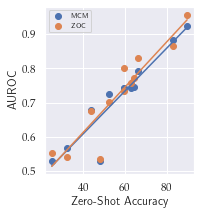

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_2


True

<Figure size 432x288 with 0 Axes>

In [34]:
fig, ax = plt.subplots(figsize=halffigsize)
x = corr_df['ZEROSHOT']
y1 = corr_df['MCM']
y2 = corr_df['ZOC']
y3 = corr_df['LOGISTIC']

plot_line(x,y1)
plot_line(x,y2)
# ax.scatter(x, y1, label= f"MCM (r = {corr_df.corr()['ZEROSHOT']['MCM'].round(2)}) ")
# ax.scatter(x, y2, label= f"ZOC (r = {corr_df.corr()['ZEROSHOT']['ZOC'].round(2)}) ")
ax.scatter(x, y1, label= f"MCM")
ax.scatter(x, y2, label= f"ZOC")
# ax.set_ylim(0.2,1.1)
# ax.set_xticklabels(corr_df.index, rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=7)
ax.set_xlabel('Zero-Shot Accuracy')
ax.set_ylabel('AUROC')
plt.tight_layout()
#plt.title('Correlation with Zero-Shot Accuracy')
plt.show()
save_plot(fig, 'corr_with_zsa', '5_2', False)

### Distances corr

In [35]:
clp = get_history_from_project('thesis-clp-temperature-100runs')
mmd = get_history_from_project('thesis-mmd-100')
clp_one_temp = clp[(clp['temperature'] < 1.13) & (clp['temperature'] > 0.98)]
clp_one_temp = clp_one_temp.drop(['temperature', 'std'], axis=1)
mmd = mmd.drop('std', axis=1)
distances = pd.concat([mmd, clp_one_temp], axis=1)

In [36]:
# quick add zsa...
# get zsa... tip_df = get_history_from_project('thesis-tip-adapters-16_shots-test')
tip_df = get_history_from_project('thesis-tip-adapters-16_shots-test')
#add zsa to distances


In [37]:
to_plot = ['ZOC','MCM', 'LOGISTIC']
distances_df = pd.concat([full_near[to_plot], distances], axis=1)
distances_df['ZSA'] = distances_df.apply(lambda x: tip_df['ZEROSHOT'][x.name], axis=1)
distances_df = distances_df.sort_values('clp')

In [38]:
distances_df.max()

ZOC          0.957453
MCM          0.923608
LOGISTIC     0.938369
mmd          0.034768
clp         -0.954776
ZSA         89.830000
dtype: float64

In [39]:
distances_df.min()

ZOC          0.536436
MCM          0.529103
LOGISTIC     0.677759
mmd          0.001023
clp         -2.486477
ZSA         24.946220
dtype: float64

In [40]:
distances_df

,ZOC,MCM,LOGISTIC,mmd,clp,ZSA
name,,,,,,
cifar10,0.957453,0.923608,0.913235,0.034768,-2.486477,89.830000
caltech101,0.866118,0.882819,0.920760,0.032801,-2.452318,83.232498
fashion mnist,0.800603,0.741620,0.725776,0.019312,-1.764627,59.560000
flowers102,0.829306,0.793749,0.924690,0.009622,-1.698843,66.449829
imagenet,0.758792,0.743026,0.794354,0.002499,-1.599292,62.840000
cifar100,0.772430,0.744651,0.787528,0.003711,-1.538185,64.230000
stanford cars,0.734188,0.742091,0.778580,0.004775,-1.494263,59.731377
caltech cub,0.700627,0.725746,0.755553,0.004373,-1.394891,52.157404
dtd,0.674364,0.678434,0.806957,0.010762,-1.308142,43.882979


In [41]:
distances_df.corr().round(2)

,ZOC,MCM,LOGISTIC,mmd,clp,ZSA
ZOC,1.00,0.98,0.37,0.71,-0.94,0.93
MCM,0.98,1.00,0.40,0.72,-0.95,0.93
LOGISTIC,0.37,0.40,1.00,0.47,-0.45,0.60
mmd,0.71,0.72,0.47,1.00,-0.87,0.71
clp,-0.94,-0.95,-0.45,-0.87,1.00,-0.92
ZSA,0.93,0.93,0.60,0.71,-0.92,1.00


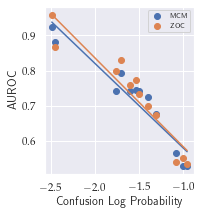

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_2


True

<Figure size 432x288 with 0 Axes>

In [42]:
fig, ax = plt.subplots(figsize=halffigsize)
x = distances_df['clp']
y1 = distances_df['MCM']
y2 = distances_df['ZOC']
y3 = distances_df['LOGISTIC']

plot_line(x,y1)
plot_line(x,y2)

# the points
# ax.scatter(x, y1, label= f"MCM (r = {distances_df.corr()['clp']['MCM'].round(2)}) ")
# ax.scatter(x, y2, label= f"ZOC (r = {distances_df.corr()['clp']['ZOC'].round(2)}) ")
ax.scatter(x, y1, label= f"MCM")
ax.scatter(x, y2, label= f"ZOC")
# config stuff
# ax.set_ylim(0.2,1.1)
# ax.set_xticklabels(corr_df.index, rotation=45, ha='right')
ax.legend(loc='upper right', fontsize=7)
ax.set_xlabel('Confusion Log Probability')
ax.set_ylabel('AUROC')
plt.tight_layout()
# plt.title('Correlation with CLP')
plt.show()
save_plot(fig, 'corr_with_clp', '5_2', False)

In [43]:
def plot_line(x,y,ax):
    new_y = line(x,y)
    ax.plot(x,new_y)

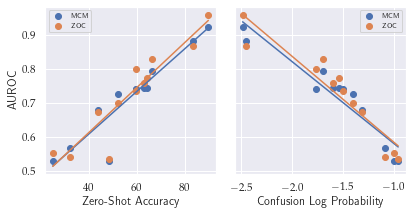

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_2
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_2


True

<Figure size 432x288 with 0 Axes>

In [44]:
fig, axs = plt.subplots(ncols=2, figsize=figsize, sharey=True)
x = corr_df['ZEROSHOT']
y1 = corr_df['MCM']
y2 = corr_df['ZOC']
y3 = corr_df['LOGISTIC']

plot_line(x,y1, axs[0])
plot_line(x,y2, axs[0])
# ax.scatter(x, y1, label= f"MCM (r = {corr_df.corr()['ZEROSHOT']['MCM'].round(2)}) ")
# ax.scatter(x, y2, label= f"ZOC (r = {corr_df.corr()['ZEROSHOT']['ZOC'].round(2)}) ")
axs[0].scatter(x, y1, label= f"MCM")
axs[0].scatter(x, y2, label= f"ZOC")
# ax.set_ylim(0.2,1.1)
# ax.set_xticklabels(corr_df.index, rotation=45, ha='right')
axs[0].legend(loc='upper left', fontsize=7)
axs[0].set_xlabel('Zero-Shot Accuracy')
axs[0].set_ylabel('AUROC')

x = distances_df['clp']
y1 = distances_df['MCM']
y2 = distances_df['ZOC']
y3 = distances_df['LOGISTIC']

plot_line(x,y1, axs[1])
plot_line(x,y2, axs[1])

# the points
# ax.scatter(x, y1, label= f"MCM (r = {distances_df.corr()['clp']['MCM'].round(2)}) ")
# ax.scatter(x, y2, label= f"ZOC (r = {distances_df.corr()['clp']['ZOC'].round(2)}) ")
axs[1].scatter(x, y1, label= f"MCM")
axs[1].scatter(x, y2, label= f"ZOC")
# config stuff
# ax.set_ylim(0.2,1.1)
# ax.set_xticklabels(corr_df.index, rotation=45, ha='right')
axs[1].legend(loc='upper right', fontsize=7)
axs[1].set_xlabel('Confusion Log Probability')


plt.tight_layout()
#plt.title('Correlation with Zero-Shot Accuracy')
plt.show()
save_plot(fig, 'corr_with_zsa_and_clp', '5_2', False)